In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/DiplomadoEPM_2019/master/Modulo3/init.py
from init import init; init(force_download=False)

In [1]:
try:
    %tensorflow_version 2.x
    print ("Using TF2 in Google Colab")
except:
    pass
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import *
from local.lib import mlutils
tf.__version__

'2.1.0'

## Neuronas biológicas

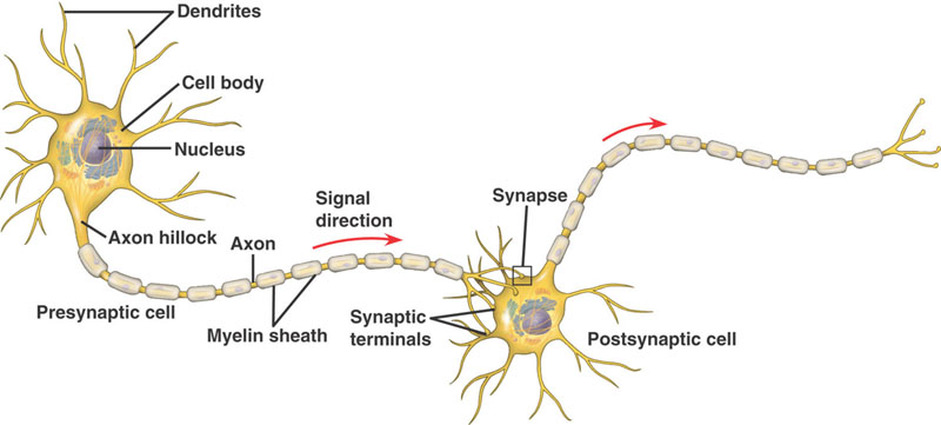

In [11]:
from IPython.display import Image
Image(filename='local/imgs/neurons.jpg', width=600)

## Simplificación como una neurona artificial

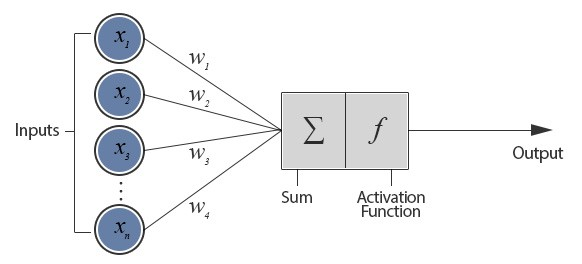

In [12]:
Image(filename='local/imgs/neuron.jpeg', width=600)

## Red de neuronas artificiales

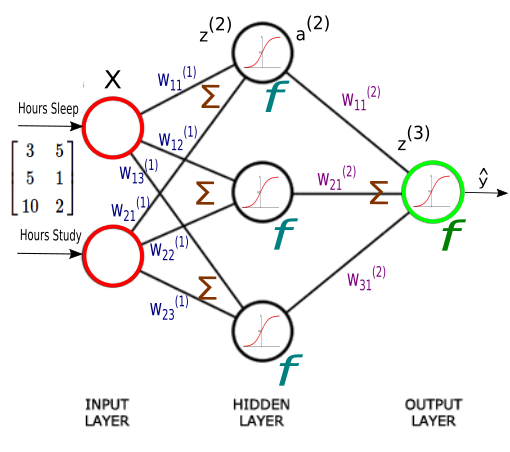

In [13]:
Image(filename='local/imgs/NN-with-components-w11-etc.png', width=400)

## El Perceptrón original

https://www.wikiwand.com/en/Perceptron

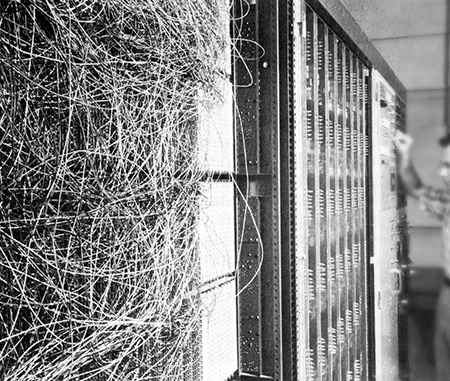

In [14]:
Image(filename='local/imgs/perceptron.jpg', width=500)

## Formulación 

**Predicción**
$$\hat{y} = \text{sigmoid}(\mathbf{W}_2 \cdot \tanh(\mathbf{x^T} \cdot \mathbf{W}_1 + \mathbf{b}_1) + b_2)$$

y recuerda que $\text{sigmoid}(z) = \frac{1}{1+e^{-z}}$

**Coste (sin regularización)**
$$J(\mathbf{b}_1, b_2, \mathbf{W}_1, \mathbf{W}_2) = \frac{1}{m}\sum_{i=0}^{m-1} (\hat{y}-y)^2$$

**Coste (con regularización)**
$$J(\mathbf{b}_1, b_2, \mathbf{W}_1, \mathbf{W}_2) = \frac{1}{m}\sum_{i=0}^{m-1} (\hat{y}-y)^2 + \lambda \left[ || \mathbf{b}_1||^2 + b_2^2 + ||\mathbf{W}_1||^2 + ||\mathbf{W}_2||^2\right]$$


observa que la función de coste contiene un conjunto de términos regulados por $\lambda$ (y que están fuera de la sumatoria). Dado un vector o matriz $\mathbf{T}$, su norma al cuadrado se denota por $||\mathbf{T}||^2 \in \mathbb{R}$ y se calcula elevando todos sus elementos al cuadrado y obteniendo su suma. Este $\lambda$ es el argumento `reg` de la clase `Model`.

Universal Approximation Theorem https://www.wikiwand.com/en/Universal_approximation_theorem


## Una red neuronal con TensorFlow

trata de identificar:

- cuales son y donde se definen los parámetros del modelo 
- dónde se define $\hat{y}$
- dónde se define $J$
- dónde se calculan los gradientes
- dónde se hace el bucle de optimización

Observa que no hemos incluído el término de regularización, aunque tenemos el constructor preparado (`reg=0.`)

In [26]:
from progressbar import progressbar as pbar

class Model:
    def __init__(self, input_shape=2, neurons=5, reg=0.):
        
        # define symbolic variables representing parameters
        self.W1 = tf.Variable(np.random.normal(size=(input_shape, neurons), scale=.6))
        self.b1 = tf.Variable(np.random.normal(size=neurons, scale=.6))
        
        self.W2 = tf.Variable(np.random.normal(size=(neurons, 1), scale=.6))
        self.b2 = tf.Variable(np.random.normal(size=1, scale=.6))
        
        self.params = [self.W1, self.b1, self.W2, self.b2]
        self.reg = reg
        self.neurons = neurons
        
    def __call__(self, X):
        # define output function (yhat)
        layer1 = tf.tanh(tf.matmul(X,self.W1)+self.b1)
        return tf.sigmoid(tf.matmul(layer1,self.W2)+self.b2)

    @tf.function
    def train_step(self, X, y, lr):
        with tf.GradientTape() as t:
            y = tf.cast(tf.reshape(y,[-1]), tf.float64)
            ypred = tf.reshape(self(X), [-1])
            
            current_loss = 100*tf.reduce_mean(tf.square( y - ypred))

            # regularization_term = ....
            # current_loss += self.reg*regularization_term
    
        grads = t.gradient(current_loss, self.params)
        for p,g in zip(self.params, grads):
            p.assign_sub( lr * g)
        return current_loss

    def fit(self, X, y, epochs=4000, lr=0.5):        
        self.hloss = []
        for epoch in pbar(range(epochs)):
            current_loss = self.train_step(X, y, lr=lr)
            self.hloss.append(current_loss.numpy())
    
    def predict(self, X):
        return (self(X).numpy()>.5).astype(int)[:,0]
    
    def plot(self, X,y):
        plt.figure(figsize=(15,4))
        ax=plt.subplot(131)
        self.draw(ax=ax)
        plt.subplot(132)
        plt.plot(self.hloss)
        plt.xlabel("epochs"); plt.ylabel("loss"); plt.grid();
        plt.subplot(133)
        mlutils.plot_2Ddata_with_boundary(self.predict, X,y)
        plt.title("classification frontier, train accuracy %.2f"%np.mean(model.predict(X)==y));        

    def draw(self, ax=None):
        ax = plt.figure(figsize=(4,4)).add_subplot(111) if not ax else ax
        mlutils.draw_neural_net(ax, .1, .9, .1, .9, [2, self.neurons, 1])
        plt.gca().set_aspect('equal', adjustable='box')
        plt.axis("off")        

observa las fronteras que se generan para el siguiente dataset con distintos número de neuronas

**TALER 1**: experimenta con:
    
- distintos niveles de ruido del dataset
- distintos números de neuronas

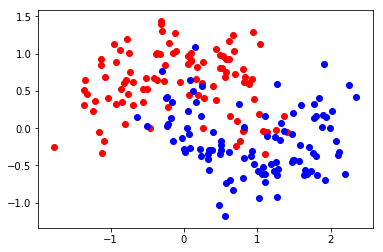

In [16]:
X, y = make_moons(200, noise=.3)

plt.scatter(X[:,0][y==0], X[:,1][y==0], color="red", label="class 0")
plt.scatter(X[:,0][y==1], X[:,1][y==1], color="blue", label="class 1")

100% (5000 of 5000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


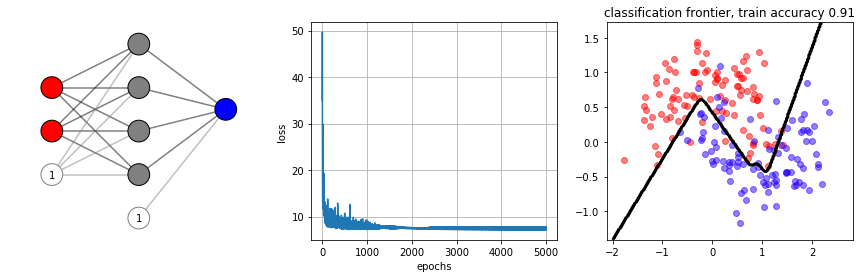

In [17]:
model = Model(neurons=4)
model.fit(X,y, epochs=5000, lr=.5)
model.plot(X,y)

100% (5000 of 5000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


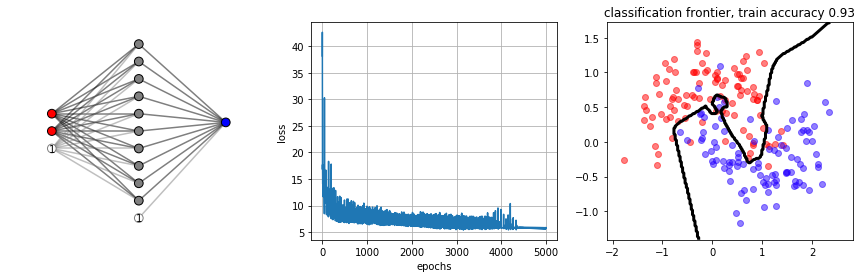

In [18]:
model = Model(neurons=10)
model.fit(X,y, epochs=5000, lr=.5)
model.plot(X,y)

**TALLER 2**: Modifica el método `train_step` de la clase `Model` para que incluya el término de regularización.

Observa que:

- estamos trabajando con Tensores (arrays multidimensionales)
- tenemos que usar siempre funciones de TensorFlow: `tf.reduce_sum`, `tf.matmul`, etc.
- los ejemplos siguientes son con un tensor `W`

In [19]:
W = tf.Variable(np.random.random(size=(2,3)))
W

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float64, numpy=
array([[0.44393924, 0.16676561, 0.322064  ],
       [0.21543644, 0.18595064, 0.00525379]])>

In [20]:
W**2

<tf.Tensor: shape=(2, 3), dtype=float64, numpy=
array([[1.97082046e-01, 2.78107672e-02, 1.03725223e-01],
       [4.64128585e-02, 3.45776403e-02, 2.76022605e-05]])>

y así se calcula $||W||$, que es la suma de todos los elementos al cuadrado

In [21]:
tf.reduce_sum(W**2)

<tf.Tensor: shape=(), dtype=float64, numpy=0.40963613736182825>

que corresponde con el mismo valor si transformamos `W` a un array de numpy

In [22]:
np.sum(W.numpy()**2)

0.4096361373618282

si vuelves a ejecutar el modelo con el parámetro de regularización como en las siguiente celdas, las fronteras deberían de ser más suaves y muy parecidas en ambos casos

100% (5000 of 5000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


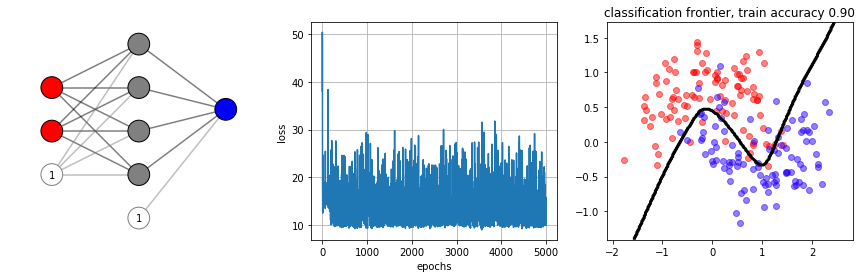

In [27]:
model = Model(neurons=4, reg=.01)
model.fit(X,y, epochs=5000, lr=.5)
model.plot(X,y)

100% (5000 of 5000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


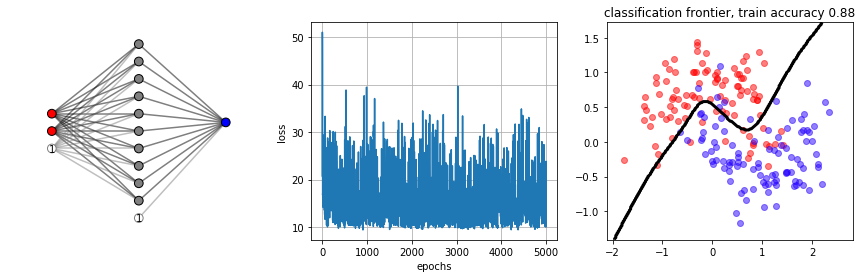

In [28]:
model = Model(neurons=10, reg=.01)
model.fit(X,y, epochs=5000, lr=.5)
model.plot(X,y)

### observe what happens if you have too much regularization

100% (5000 of 5000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


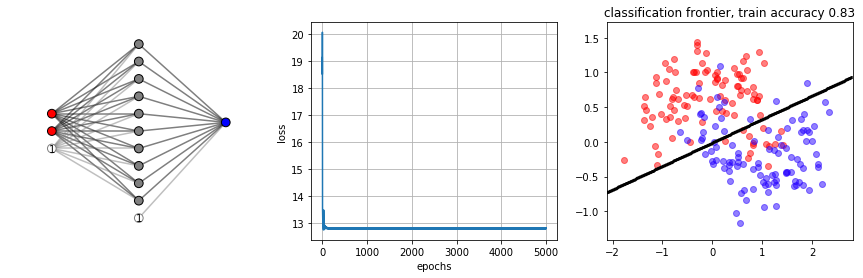

In [29]:
model = Model(neurons=10, reg=.2)
model.fit(X,y, epochs=5000, lr=.1)
model.plot(X,y)

### descomenta las siguientes líneas para ver la solución de este taller

In [25]:
#s = [99, 117, 114, 114, 101, 110, 116, 95, 108, 111, 115, 115, 32, 43, 61, 32, 115, 101, 108, 102, 46, 114, 101, 103, 42, 116, 102, 46, 114, 101, 100, 117, 99, 101, 95, 115, 117, 109, 40, 91, 116, 102, 46, 114, 101, 100, 117, 99, 101, 95, 115, 117, 109, 40, 105, 42, 42, 50, 41, 32, 102, 111, 114, 32, 105, 32, 105, 110, 32, 115, 101, 108, 102, 46, 112, 97, 114, 97, 109, 115, 93, 41]
#print ("".join([chr(i) for i in s]))